In [1]:
import tensorflow as tf 

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from sionna.phy.ofdm import ResourceGrid
from sionna.phy.channel.tr38901 import CDL, PanelArray, UMa
from sionna.phy.channel import OFDMChannel

In [2]:
# Panel array configuration for the transmitter and receiver

rg = ResourceGrid(
    num_ofdm_symbols=256,
    fft_size=76,
    subcarrier_spacing=30e3,
    num_tx=1,
    num_streams_per_tx=1,
    cyclic_prefix_length=1
)

BS_ARRAY = PanelArray(num_rows_per_panel = 16,
    num_cols_per_panel = 1,
    polarization = 'single',
    polarization_type = 'V',
    antenna_pattern = 'omni',
    carrier_frequency = 3.5e9)

UT_ARRAY = PanelArray(num_rows_per_panel = 1,
    num_cols_per_panel = 1,
    polarization = 'single',
    polarization_type = 'V',
    antenna_pattern = 'omni',
    carrier_frequency = 3.5e9)


In [3]:
1/ rg.ofdm_symbol_duration, rg._subcarrier_spacing, rg.ofdm_symbol_duration

(29610.38961038961, 30000.0, 3.37719298245614e-05)

In [4]:
channel_model = UMa(carrier_frequency = 3.5e9,
    o2i_model = 'low',
    ut_array = UT_ARRAY,
    bs_array = BS_ARRAY,
    direction = 'downlink')

In [5]:
# UT_LOC = tf.zeros([5, 1, 3], dtype=tf.float32)
# BS_LOC = tf.zeros([5, 1, 3], dtype=tf.float32)
# UT_ORIENTATION = tf.zeros([5, 1, 3], dtype=tf.float32)
# BS_ORIENTATION = tf.zeros([5, 1, 3], dtype=tf.float32)
# UT_VELOCITIES = tf.zeros([5, 1, 3], dtype=tf.float32)
# IN_STATE = tf.zeros([5, 1], dtype=tf.bool)
# LOS = True
# BS_VIRTUAL_LOS = None

# batch_size = 5

# # ----- Base Station locations (fixed at origin, 25 m height)
# BS_LOC = tf.constant([[[0.0, 0.0, 25.0]]] * batch_size, dtype=tf.float32)

# # ----- User Terminal locations (randomly placed around the BS)
# radii = np.random.uniform(50, 500, batch_size)        # distance in meters
# angles = np.random.uniform(0, 2*np.pi, batch_size)    # azimuth angle in radians
# UT_LOC = tf.constant([
#     [[radii[i]*np.cos(angles[i]), radii[i]*np.sin(angles[i]), 1.5]] 
#     for i in range(batch_size)
# ], dtype=tf.float32)

# # ----- Base Station orientation (down-tilt ~10°, facing x-axis)
# BS_ORIENTATION = tf.constant([[[0.0, -np.deg2rad(10), 0.0]]] * batch_size, dtype=tf.float32)

# # ----- User Terminal orientation (random yaw, level pitch/roll)
# UT_ORIENTATION = tf.constant([
#     [[np.random.uniform(-np.pi, np.pi), 0.0, 0.0]]
#     for _ in range(batch_size)
# ], dtype=tf.float32)

# # ----- User velocities (random directions, 0–15 m/s)
# speeds = np.random.uniform(0, 15, batch_size)
# headings = np.random.uniform(0, 2*np.pi, batch_size)
# UT_VELOCITIES = tf.constant([
#     [[speeds[i]*np.cos(headings[i]), speeds[i]*np.sin(headings[i]), 0.0]]
#     for i in range(batch_size)
# ], dtype=tf.float32)

# # --- Check values ---
# print("BS_LOC:\n", BS_LOC.numpy())
# print("UT_LOC:\n", UT_LOC.numpy())
# print("UT_VELOCITIES:\n", UT_VELOCITIES.numpy())


In [83]:
batch_size = 5

# ----- User Terminal locations (100, 0, 25 m height)
UT_LOC = tf.constant([[[100.0, 0.0, 25.0]]] * batch_size, dtype=tf.float32)

# ----- Base Station locations (fixed at origin, 25 m height)
BS_LOC = tf.constant([[[0.0, 0.0, 25.0]]] * batch_size, dtype=tf.float32)

# UT_ORIENTATION = tf.ones([5, 1, 3], dtype=tf.float32) # Radians
# BS_ORIENTATION = tf.ones([5, 1, 3], dtype=tf.float32) # Radians

# convention used here: [azimuth, elevation, roll] in radians
# BS_ORIENTATION = tf.constant([[[0.0, -0.1974, 0.0]]] * batch_size, dtype=tf.float32)
# UT_ORIENTATION = tf.constant([[[3.1415927,  0.1974,  0.0]]] * batch_size, dtype=tf.float32)

BS_ORIENTATION = tf.constant([[[0.0, 0.0, 0.0]]] * batch_size, dtype=tf.float32)
UT_ORIENTATION = tf.constant([[[0.0, 0.0,  0.0]]] * batch_size, dtype=tf.float32)


speed = 25 # m/s
UT_VELOCITIES = tf.constant([[[speed, 0.0, 0.0]]] * batch_size, dtype=tf.float32)

IN_STATE = tf.zeros([5, 1], dtype=tf.bool) # Outdoor -> zero; Indoor -> ones
LOS = True # False - > NLOS included; True -> only LOS
BS_VIRTUAL_LOS = None

In [84]:
channel_model.set_topology(
    ut_loc=UT_LOC,
    bs_loc=BS_LOC,
    ut_orientations=UT_ORIENTATION,
    bs_orientations=BS_ORIENTATION,
    ut_velocities=UT_VELOCITIES,
    in_state=IN_STATE,
    los=LOS,
    bs_virtual_loc=BS_VIRTUAL_LOS
)

In [85]:
channel = OFDMChannel(
    channel_model=channel_model,
    resource_grid=rg,
    return_channel=True
)

In [86]:
y, h_freq = channel(tf.zeros([batch_size, 1, 16, rg.num_ofdm_symbols, rg.fft_size], dtype=tf.complex64))
y.shape, h_freq.shape

# Output: y-> Channel output, h_freq -> Channel freq response
# Output
#     -------
#     y : [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], `tf.complex`
#         Channel outputs
#     h_freq : [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, fft_size], `tf.complex`
#         (Optional) Channel frequency responses

(TensorShape([5, 1, 1, 256, 76]), TensorShape([5, 1, 1, 1, 16, 256, 76]))

### COnverting it to Delay Angle

In [87]:
# Step 1: IFFT over delay (last dimension)
h_dd = tf.signal.ifft(h_freq)  # shape: [B, Rx, RxAnt, Tx, TxAnt, Doppler, Delay]
h_dd = tf.signal.ifftshift(h_dd, axes=-1)
# Step 2: FFT over Doppler (2nd-last dimension)
h_dd = tf.transpose(h_dd, perm=[0, 1, 2, 3, 6, 5, 4])  # move Doppler to last
h_dd = tf.signal.fft(h_dd) # FFT over Doppler axis
h_dd = tf.signal.fftshift(h_dd, axes=-1)
h_dd = tf.transpose(h_dd, perm=[0, 1, 2, 3, 4, 5, 6])  # restore original order

In [88]:
h_tf_reduced = tf.squeeze(h_freq)
print(h_tf_reduced.shape)
h_tf_reordered = tf.transpose(h_tf_reduced, perm=[0, 2, 1, 3])
print(h_tf_reordered.shape)

(5, 16, 256, 76)
(5, 256, 16, 76)


In [89]:
h_dd_reduced = tf.squeeze(h_dd) # Removes the dimesnion of size 1
print(h_dd_reduced.shape)
h_dd_reordered = tf.transpose(h_dd_reduced, perm=[0, 2, 3, 1])
print(h_dd_reordered.shape)

(5, 76, 256, 16)
(5, 256, 16, 76)


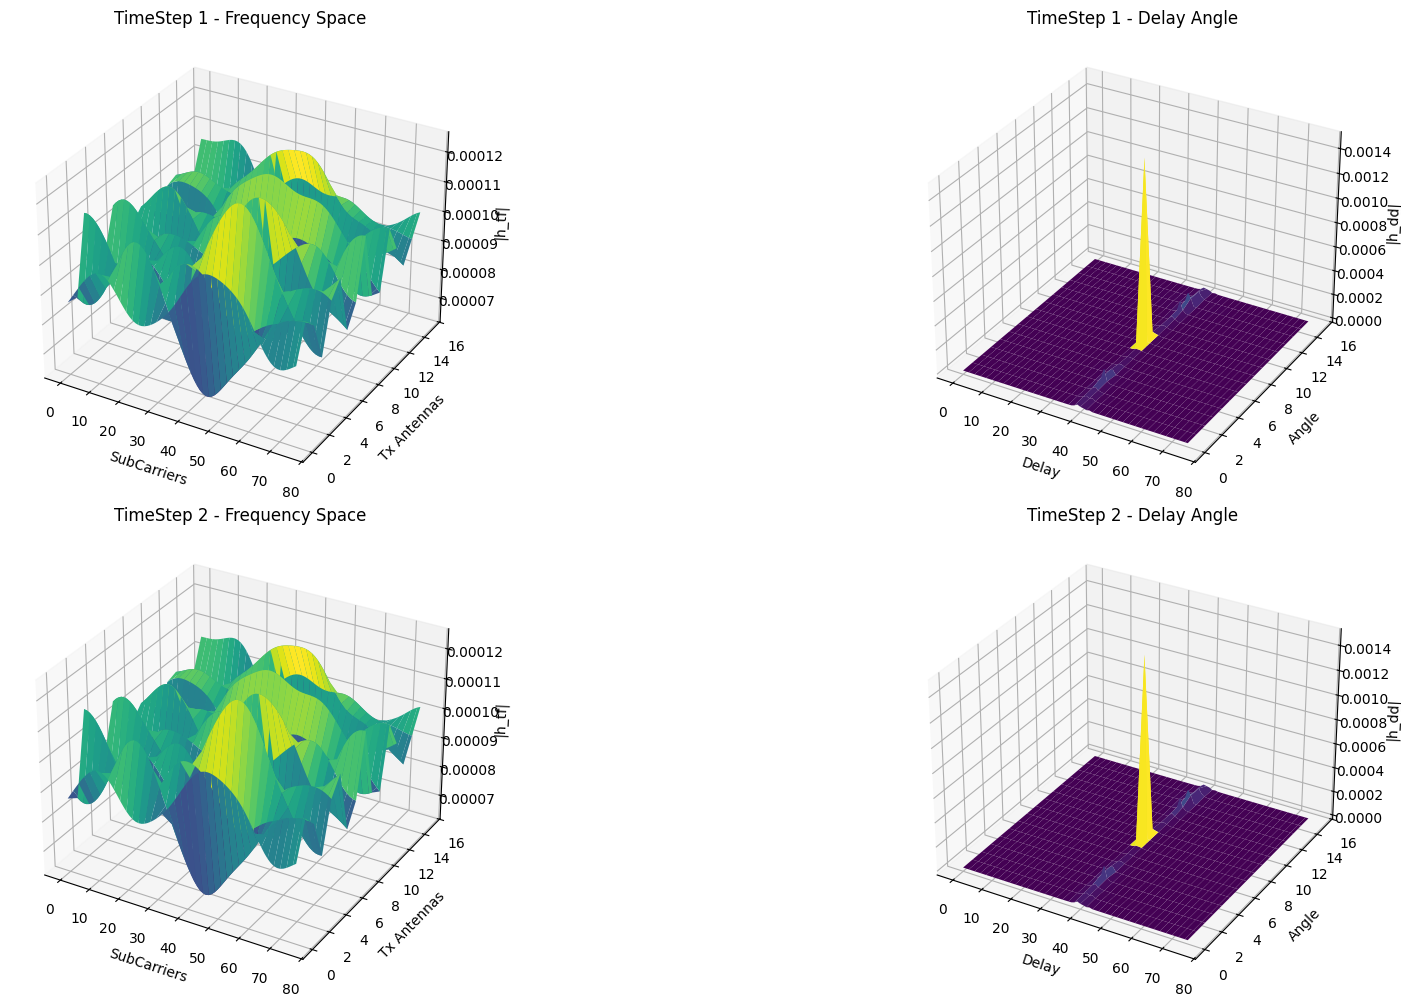

In [90]:
# Plotting/ verifying data from loaded tensors.
fig = plt.figure(figsize=(18, 25))  # Wider and taller figure for 5x2 layout

for i in range(2):
    # --- Time-Frequency (Left Column) ---
    h_tf_mag = tf.abs(h_tf_reordered[1, i, :, :]).numpy()
    time_bins, freq_bins = h_tf_mag.shape
    X_tf, Y_tf = np.meshgrid(np.arange(freq_bins), np.arange(time_bins))

    ax1 = fig.add_subplot(5, 2, 2*i + 1, projection='3d')
    ax1.plot_surface(X_tf, Y_tf, h_tf_mag, cmap='viridis')
    ax1.set_title(f"TimeStep {i+1} - Frequency Space")
    ax1.set_xlabel("SubCarriers")
    ax1.set_ylabel("Tx Antennas")
    ax1.set_zlabel("|h_tf|")

    # --- Delay-Doppler (Right Column) ---
    h_dd_mag = tf.abs(h_dd_reordered[1, i, :, :]).numpy()
    doppler_bins, delay_bins = h_dd_mag.shape
    X_dd, Y_dd = np.meshgrid(np.arange(delay_bins), np.arange(doppler_bins))

    
    ax2 = fig.add_subplot(5, 2, 2*i + 2, projection='3d')
    ax2.plot_surface(X_dd, Y_dd, h_dd_mag, cmap='viridis')
    ax2.set_title(f"TimeStep {i+1} - Delay Angle")
    ax2.set_xlabel("Delay")
    ax2.set_ylabel("Angle")                                    
    ax2.set_zlabel("|h_dd|")

plt.tight_layout()
# plt.savefig('CSI - CDL.png')
plt.show()

### Delay Doppler visualization

In [91]:
# Step 1: IFFT over delay (last dimension)
h_dd = tf.signal.ifft(h_freq)  # shape: [B, Rx, RxAnt, Tx, TxAnt, Doppler, Delay]
h_dd = tf.signal.ifftshift(h_dd, axes=-1)
# Step 2: FFT over Doppler (2nd-last dimension)
h_dd = tf.transpose(h_dd, perm=[0, 1, 2, 3, 4, 6, 5])  # move Doppler to last
h_dd = tf.signal.fft(h_dd) # FFT over Doppler axis
h_dd = tf.signal.fftshift(h_dd, axes=-1)
h_dd = tf.transpose(h_dd, perm=[0, 1, 2, 3, 4, 5, 6])  # restore original order

In [92]:
h_tf_reduced = tf.squeeze(h_freq)
print(h_tf_reduced.shape)

h_dd_reduced = tf.squeeze(h_dd) # Removes the dimesnion of size 1
print(h_dd_reduced.shape)

h_dd_reordered = tf.transpose(h_dd_reduced, perm=[0, 1, 3, 2])
print(h_dd_reordered.shape)

(5, 16, 256, 76)
(5, 16, 76, 256)
(5, 16, 256, 76)


In [93]:
N_sym = rg.num_ofdm_symbols
T_sym = rg.ofdm_symbol_duration

f_d = 1 / (N_sym * T_sym)

v_d = 0.08571 * f_d

In [94]:
v_d

9.91369724025974

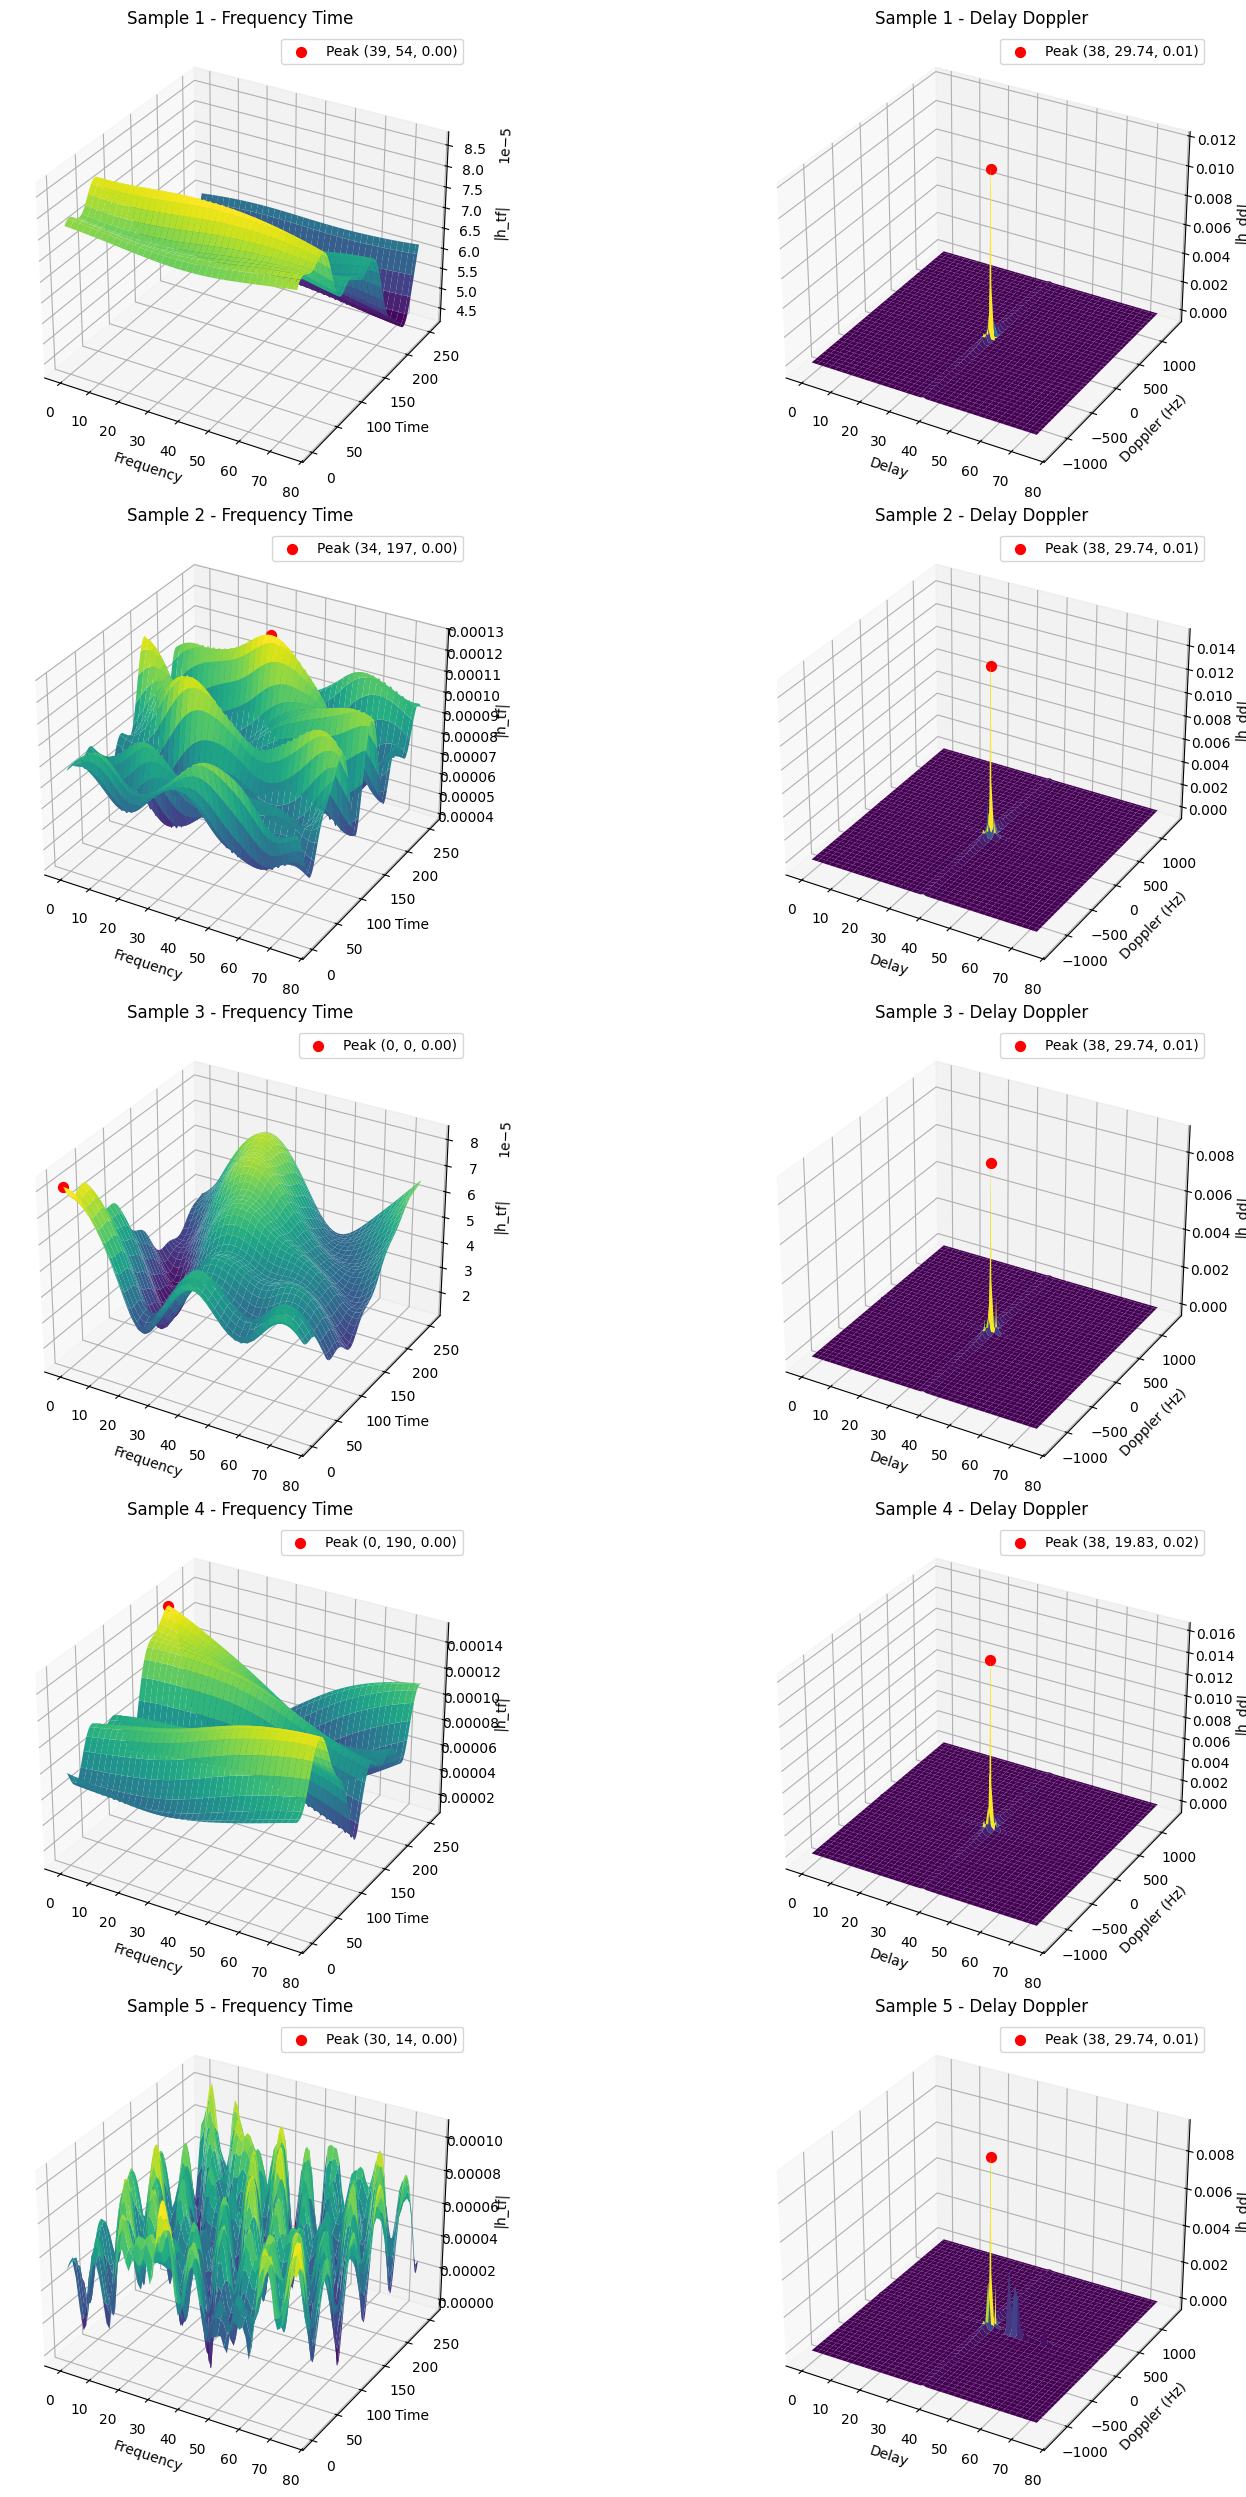

In [95]:


fig = plt.figure(figsize=(18, 25))  # Wider and taller figure for 5x2 layout

# Optional: enable interactive 3D rotation if you're in Jupyter
# %matplotlib widget

for i in range(5):  # change to range(5) if you want 5 samples
    # --- Time-Frequency (Left Column) ---
    h_tf_mag = tf.abs(h_tf_reduced[i, 0, :, :]).numpy()
    time_bins, freq_bins = h_tf_mag.shape
    X_tf, Y_tf = np.meshgrid(np.arange(freq_bins), np.arange(time_bins))

    ax1 = fig.add_subplot(5, 2, 2*i + 1, projection='3d')
    surf1 = ax1.plot_surface(X_tf, Y_tf, h_tf_mag, cmap='viridis')

    # Find and mark peak
    peak_idx = np.unravel_index(np.argmax(h_tf_mag), h_tf_mag.shape)
    x_peak, y_peak, z_peak = X_tf[peak_idx], Y_tf[peak_idx], h_tf_mag[peak_idx]

    ax1.scatter(x_peak, y_peak, z_peak, color='r', s=50, label=f"Peak ({x_peak}, {y_peak}, {z_peak:.2f})")
    ax1.legend(loc='upper right')

    ax1.set_title(f"Sample {i+1} - Frequency Time")
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Time")
    ax1.set_zlabel("|h_tf|")

    # --- Delay-Doppler (Right Column) ---
    h_dd_mag = tf.abs(h_dd_reordered[i, 0, :, :]).numpy()
    doppler_bins, delay_bins = h_dd_mag.shape
    X_dd, Y_dd = np.meshgrid(np.arange(delay_bins), np.arange(doppler_bins))
    # Y_dd = (Y_dd - len(Y_dd) / 2) * f_d # to get outputs in terms of doppler
    
    Y_dd = (Y_dd - len(Y_dd) / 2) * v_d # to get outputs in terms of speed

    ax2 = fig.add_subplot(5, 2, 2*i + 2, projection='3d')
    surf2 = ax2.plot_surface(X_dd, Y_dd, h_dd_mag, cmap='viridis')

    # Find and mark peak
    peak_idx_dd = np.unravel_index(np.argmax(h_dd_mag), h_dd_mag.shape)
    x_peak_dd, y_peak_dd, z_peak_dd = X_dd[peak_idx_dd], Y_dd[peak_idx_dd], h_dd_mag[peak_idx_dd]

    ax2.scatter(x_peak_dd, y_peak_dd, z_peak_dd, color='r', s=50, label=f"Peak ({x_peak_dd}, {y_peak_dd:.2f}, {z_peak_dd:.2f})")
    ax2.legend(loc='upper right')

    ax2.set_title(f"Sample {i+1} - Delay Doppler")
    ax2.set_xlabel("Delay")
    ax2.set_ylabel("Doppler (Hz)")
    ax2.set_zlabel("|h_dd|")

plt.tight_layout()
plt.show()
